"Our ability to measure and alter biology far surpasses our ability to actually understand it"
Ed Regis, What is life?

We know very little about the complexity of biological processes, compared to the accuracy we have achieved in observing and even engineering them. Imaging, synthesis and sequencing techniques can be used in perspective to build complex genetic circuits that replicate pre-programmed metabolic processes \cite{VoigtRNA}, and to advance the diagnosis and treatment of many diseases poorly known today. State of the art is still far from this goal, but a lot of cutting edge research is being dedicated to integrating Engineering, Biology, Physics and Computer Science to better understand biological processes and analyze biomedical data.

After briefly introducing both the segmentation problem in general, with a focus on the segmentation of biomedical images and its relevance in the first section, in the second section of the review, we will give a deeper insight into our work environment and its features. In the third section, we will describe the dataset used to train the network, the pre-processing steps we performed to uniform and analyze it, and the purpose and features of the data augmentation we implemented. In the fourth section, we will describe the architecture of the network, characterizing all the layers. As already mentioned, our network is based on U-Net, a fully connected convolutional network developed at the Computer Science Department of the University of Freiburg, Germany, but we will stress our personal contributions. Before ultimately presenting the performances of the network on two different datasets and summarizing the conclusions and outlook of the work recapped in this report, in the fifth section we will delineate the features of the scheduling of optimizations parameters and tuning of the hyperparameters.

In [ ]:
#####INSTALL PACKAGES#####
!pip install googledrivedownloader
!pip install elasticdeform
!pip install optuna

#####NUMPY#####
import numpy as np
from numpy import asarray

#####TORCHVISION#####
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision import datasets , models , transforms

#####TORCH#####
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset , DataLoader
from torch.nn import BCEWithLogitsLoss 
from torch.optim.lr_scheduler import CosineAnnealingLR

#####RANDOM#####
import random

#####TYPING#####
from typing import List, Tuple, Mapping , Union , Optional, Callable

#####OS#####
import os
from os import listdir
from os.path import isfile, join

#####DRIVE DOWNLOADER#####
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive

#####TQDM#####
from tqdm.notebook import tqdm

#####PIL#####
from PIL import Image

#####MATPLOTLIB#####
import matplotlib.pyplot as plt

#####ELASTIC DEFORM#####
import elasticdeform

#####MATH#####
import math

#####CV2#####
import cv2

#####PLOTLY#####
import plotly.graph_objects as go
import plotly.express as px

#####PICKLE#####
import pickle

#####OPTUNA#####
import optuna

#####REQUEST#####
import requests 

#####SKLEARN#####
from sklearn.metrics import f1_score

from __future__ import print_function , division

  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70435 sha256=8a6fe17e55bc1379e2b060d160491bd9b351ae9459204bd5162ed09a0b59e9be
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform
     |████████████████████████████████| 235kB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 112kB 16.2MB/s 
     |████████████████████████████████| 133kB 14.9MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
  Created wheel for optuna: filename=optuna-2.1.0

In [ ]:
#drive.mount('/content/drive')

##**UTILITY SECTION**

##**Visualization**

In [ ]:
def plot_data_from_to(init: int, end: int):
  """
  Visualize dataset
  :param init: first image visualized (included)
  :param end: last image visualized (included)
  """

  fig= plt.figure(figsize=(18, 18))
  N = (end-init+1)*2
  rows = int(np.sqrt(N))+1
  columns = rows 
  #print(N,rows,columns)
  i = 1

  while i < N + 1 :

    img, seg = dataset[init]
    fig.add_subplot(rows, columns, i)
    plt.imshow(torch.einsum('ijk->jki',img))
    plt.title('Data %i' % (init))
    plt.axis('off')

    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(seg, cmap="gray")
    plt.title('Segmentation %i' % (init))
    plt.axis('off')
    
    init+=1
    i=i+2

  plt.show()

def plot_data(data: Tuple, title = 'Dataset sample'):
  """
  Visualize dataset couple
  :param data: the images to visualize
  :param title: the title of plot
  """
  fig= plt.figure(figsize=(15, 15))
  columns = 2
  rows = 1
  img = data[0]
  fig.add_subplot(rows, columns, 1)
  plt.title('Data')
  plt.imshow(torch.einsum('ijk->jki',img))

  img = data[1]
  fig.add_subplot(rows, columns, 2)
  plt.imshow(img, cmap="gray")
  plt.title('Segmentation')

  plt.show()


##**Model dimension check**

In [ ]:
def check_model(model, dataloader):

  def dimensionality_check(model,sample)-> T.Tensor:
    print("(batch_size, channels, w, h)")
    model.eval()
    out = model(sample,dim_check=False)
    out = out.detach()
    out = out.squeeze()
    return out

  #Prendo il primo batch del dataloader
  X_y = next(iter(dataloader))
  X = X_y[0]
  y = X_y[1]
  target = y[0,:,:]
  sample = X[0,:,:,:]
  sample = sample.unsqueeze(0)
  print("Sample shape ",sample.shape)
  print("Target shape ",target.shape)
  sample = sample.cuda()
  target = target.cuda()

  #nel dimensionality_check l'output diventa (1,1,512,512), per confrontarlo con il
  #target usando la loss devo levare le prime due dimensioni
  out = dimensionality_check(model,sample)
  #target = target.squeeze(0)

  loss = DiceLoss()
  print("LOSS_VALUE ",loss(out,target.float()))

  ######## NECESSARIE SOLO PER LA STAMPA##########
  target = y[0,:,:]
  sample = X[0,:,:,:]

  sample = torch.einsum("zxy->xyz",sample)
  target = target.squeeze(0)
  out = out.to("cpu")
  out = (out >= 0.5 )*1
  ######## NECESSARIE SOLO PER LA STAMPA##########

  w=10
  h=10
  fig=plt.figure(figsize=(12, 12))
  columns = 3
  rows = 1
  for i,img in zip(range(1, columns*rows +1),[sample,out,target]):
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

#**Hyperparameters**

In [ ]:
#####HYPERPARAMETERS#####

#####1-optimizer#####
lr = 0.8
momentum = 0.9

#####2-trainer#####
epochs = 50

#####3-dataloader#####
batch_size = 16



#**DATASET SECTION**

##**Dataset download from drive**

In [ ]:
gdd.download_file_from_google_drive(file_id='1P_0WoOWPaxGctzp_8I2NDJDWxk41rLp7',
                                    dest_path='./data/train.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
INSTANCES_PATH = "/content/data/train/instances/"
TARGETS_PATH = "/content/data/train/targets/"

##**Dataset class**

In [ ]:
class CellsDataset(Dataset):
    """Constructs cell dataset"""

    def __init__(self, X_path, y_path):
        super().__init__()
        self.X,self.y = self.get_data(X_path, y_path)


    def transform(self, image, mask):

        # Random horizontal flipping
        if random.random() > 0.5:
            #print("HFLIP")
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            #print("VFLIP")
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation
        if random.random() > 0.5:
            #print("rotation")
            degree = random.randint(0,359)
            image = TF.rotate(image,degree)
            mask = TF.rotate(mask,degree)

        # Random deformation
        if random.random() > 0.5:
          [image, mask] = elasticdeform.deform_random_grid([np.array(image), np.array(mask)], axis=[(0, 1), (0, 1)], prefilter=False)

        mask = np.array(mask)
        mask = (mask > 127) * 1
          
        image = TF.to_tensor(image).float()

        mask = TF.to_tensor(mask)

        # Random erase
        if random.random() > 0.5:
              height = 256 - 1
              width = 256 - 1
              x_upperleft = random.randint(0,width)
              y_upperleft = random.randint(0,width)
              erased_height = random.randint(1,100)
              erased_width = random.randint(1,100)
              value = 0.0
              image = TF.erase(image, x_upperleft, y_upperleft, erased_height, erased_width, value)
              mask = TF.erase(mask, x_upperleft, y_upperleft, erased_height, erased_width, value)

        mask = mask.squeeze()

        return image,mask

    def get_data(self, X_path: str, y_path: str)-> Tuple[List,List]:

      X_list = []
      y_list = []
      
      file_list = os.listdir(X_path)

      for f in tqdm(file_list):

        #Read images
        PIL_X = Image.open(X_path + f).convert("RGB")
        PIL_y = Image.open(y_path + "target_"+f).convert("L")

        X_list.append(PIL_X)
        y_list.append(PIL_y) 

      return X_list,y_list

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        out = self.transform(self.X[idx],self.y[idx])
        return out

In [ ]:
dataset = CellsDataset(INSTANCES_PATH,TARGETS_PATH)

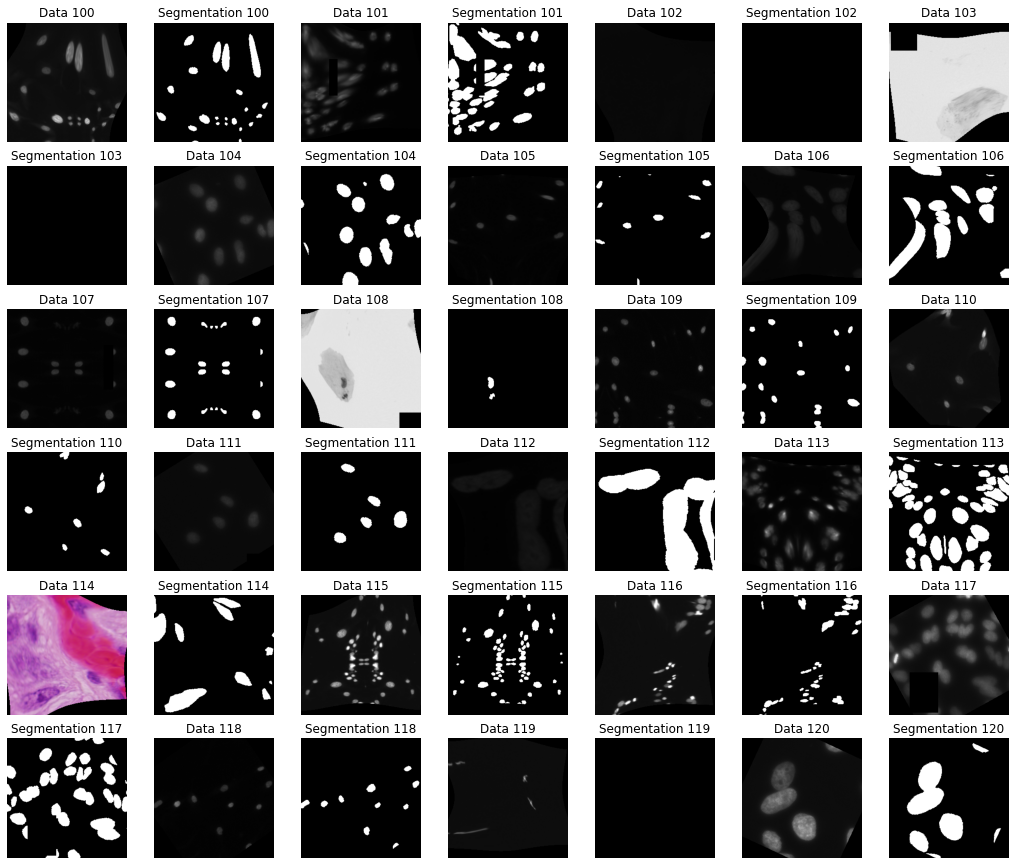

In [ ]:
plot_data_from_to(100,120)

##**Train, test, validation split**

In [ ]:
lenght = len(dataset)

train_len,test_len,validation_len = math.floor(lenght*0.7),math.ceil(lenght*0.2),math.ceil(lenght*0.1)

train,test,validation = random_split(dataset,(train_len,test_len,validation_len))


In [ ]:
print(len(train))
print(len(test))
print(len(validation))

2483
710
355


##**Dataloader**

In [ ]:
train_dataloader = DataLoader(train, batch_size=batch_size, 
                              shuffle=True,num_workers=4,drop_last=True)
test_dataloader = DataLoader(test,batch_size=batch_size,drop_last=True)
validation_dataloader = DataLoader(validation,batch_size=batch_size,drop_last=True)

#**MODEL SECTION**

##**Encoder class**

In [ ]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


class Encoder(nn.Module):

  '''
  Encoder inspired by vgg16_bn from pytorch
  Reference: https://arxiv.org/abs/1409.1556
  '''

  def __init__(self, features, init_weights=False):

      super(Encoder, self).__init__()
      self.features = features

  def forward(self, x):
      x = self.features(x)
      return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3 
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)



##**Decoder class**

In [ ]:
class decoder_block(nn.Module): 
  def __init__(self, 
               latent_dim: int, 
               hidden_channels: int, 
               out_channels: int) -> None:

    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = latent_dim, 
                           out_channels = hidden_channels, 
                           kernel_size = 3,  
                           padding = 1)
    self.upconv1 = nn.ConvTranspose2d(hidden_channels, out_channels, 4, 2, 1)

    self.activation = nn.ReLU(inplace = True) 

  def forward(self, x: T.Tensor) -> T.Tensor:
    x = self.conv1(x)
    x = self.activation(x)
    x = self.upconv1(x)
    x = self.activation(x)

    return x

In [ ]:
decoder_blocks_list = [decoder_block(256 + 512, 512, 256),
                       decoder_block(256 + 512, 512, 256),
                       decoder_block(256 + 256, 256, 64),
                       decoder_block(64 + 128, 128, 32),
                       decoder_block(latent_dim = 512, 
                                    hidden_channels = 512, 
                                    out_channels = 256)]

##**Segmentation class**

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self, decoder_blocks_list, encoder = None, pretrained = True, freeze = False, batch_norm=True):
    super().__init__()
    if pretrained:
      from torchvision import models
      if batch_norm:
        encoder_feat = models.vgg16_bn(pretrained=True).features
      else:
        encoder_feat = models.vgg16(pretrained=True).features
    else: 
      encoder_feat = encoder.features
      
    if freeze:
        for param in encoder_feat.parameters(): 
          param.requires_grad = False  

    if batch_norm:
      self.encoder1 = encoder_feat[:6]
      self.encoder2 = encoder_feat[6:13]
      self.encoder3 = encoder_feat[13:23]
      self.encoder4 = encoder_feat[23:33]
      self.encoder5 = encoder_feat[33:43]
      
    else:
      self.encoder1 = encoder_feat[:4]
      self.encoder2 = encoder_feat[4:9]
      self.encoder3 = encoder_feat[9:16]
      self.encoder4 = encoder_feat[16:23]
      self.encoder5 = encoder_feat[23:30]

    
    self.decoder1 = decoder_blocks_list[0] 
    self.decoder2 = decoder_blocks_list[1]
    self.decoder3 = decoder_blocks_list[2]
    self.decoder4 = decoder_blocks_list[3]

    self.decoder_mid = decoder_blocks_list[4]


    self.mid = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), 
                             self.decoder_mid)

    self.decoder5 = nn.Sequential(nn.Conv2d(32 + 64, 32, 3, padding = 1), 
                                  nn.ReLU(inplace = True))

    self.output = nn.Conv2d(in_channels = 32, 
                            out_channels = 1, 
                            kernel_size = 1)


  def forward(self, x: T.Tensor, dim_check = False) -> T.Tensor:
    encoder1 = self.encoder1(x)
    encoder2 = self.encoder2(encoder1)
    encoder3 = self.encoder3(encoder2)
    encoder4 = self.encoder4(encoder3)
    encoder5 = self.encoder5(encoder4)

    mid = self.mid(encoder5)

    decoder1 = self.decoder1(T.cat([mid, encoder5], 1))
    decoder2 = self.decoder2(T.cat([decoder1, encoder4], 1))
    decoder3 = self.decoder3(T.cat([decoder2, encoder3], 1))
    decoder4 = self.decoder4(T.cat([decoder3, encoder2], 1))
    decoder5 = self.decoder5(T.cat([decoder4, encoder1], 1))
    output = self.output(decoder5)
    if dim_check:
      print("input -> ",x.shape)
      print("  encoder_1 -> ",encoder1.shape)
      print("     encoder_2 -> ",encoder2.shape)
      print("       encoder_3 -> ",encoder3.shape)
      print("         encoder_4 -> ",encoder4.shape)
      print("           encoder_5 -> ",encoder5.shape)
      print("           mid       -> ",mid.shape)
      print("         decoder1 -> ",decoder1.shape)
      print("       decoder2 -> ",decoder2.shape)
      print("     decoder3 -> ",decoder3.shape)
      print("   decoder4 -> ",decoder4.shape)
      print(" decoder5 -> ",decoder5.shape)
      print("output -> ",output.shape)
    return output

##**Dice loss**

In [ ]:
class DiceLoss(nn.Module):

  def __init__(self):
    super().__init__()
    self.sigmoid = torch.nn.Sigmoid()

  def _dice_coefficient(self,pred,target,alpha):

    soft_out = self.sigmoid(pred)
    
    flat_soft_out = soft_out.reshape(16,1,-1)
    flat_target = target.reshape(16,1,-1)

    intersection = torch.sum(torch.mul(flat_soft_out , flat_target),dim=2)

    A_sum = torch.sum(flat_soft_out,dim=2)
    B_sum = torch.sum(flat_target,dim=2)

    dice_coeff = ((torch.tensor(2.,device="cuda") * intersection + alpha) / (A_sum + B_sum + alpha) ).to("cuda")
    
    return torch.mean(dice_coeff)

  def _dice_loss(self,pred,target,alpha):

    return torch.tensor(1.,device="cuda") - self._dice_coefficient(pred,target,alpha)

  def forward(self,pred,target,alpha=torch.tensor(1e-8,device="cuda")):

    return self._dice_loss(pred,target,alpha)


#**Hyperparameter tuning**
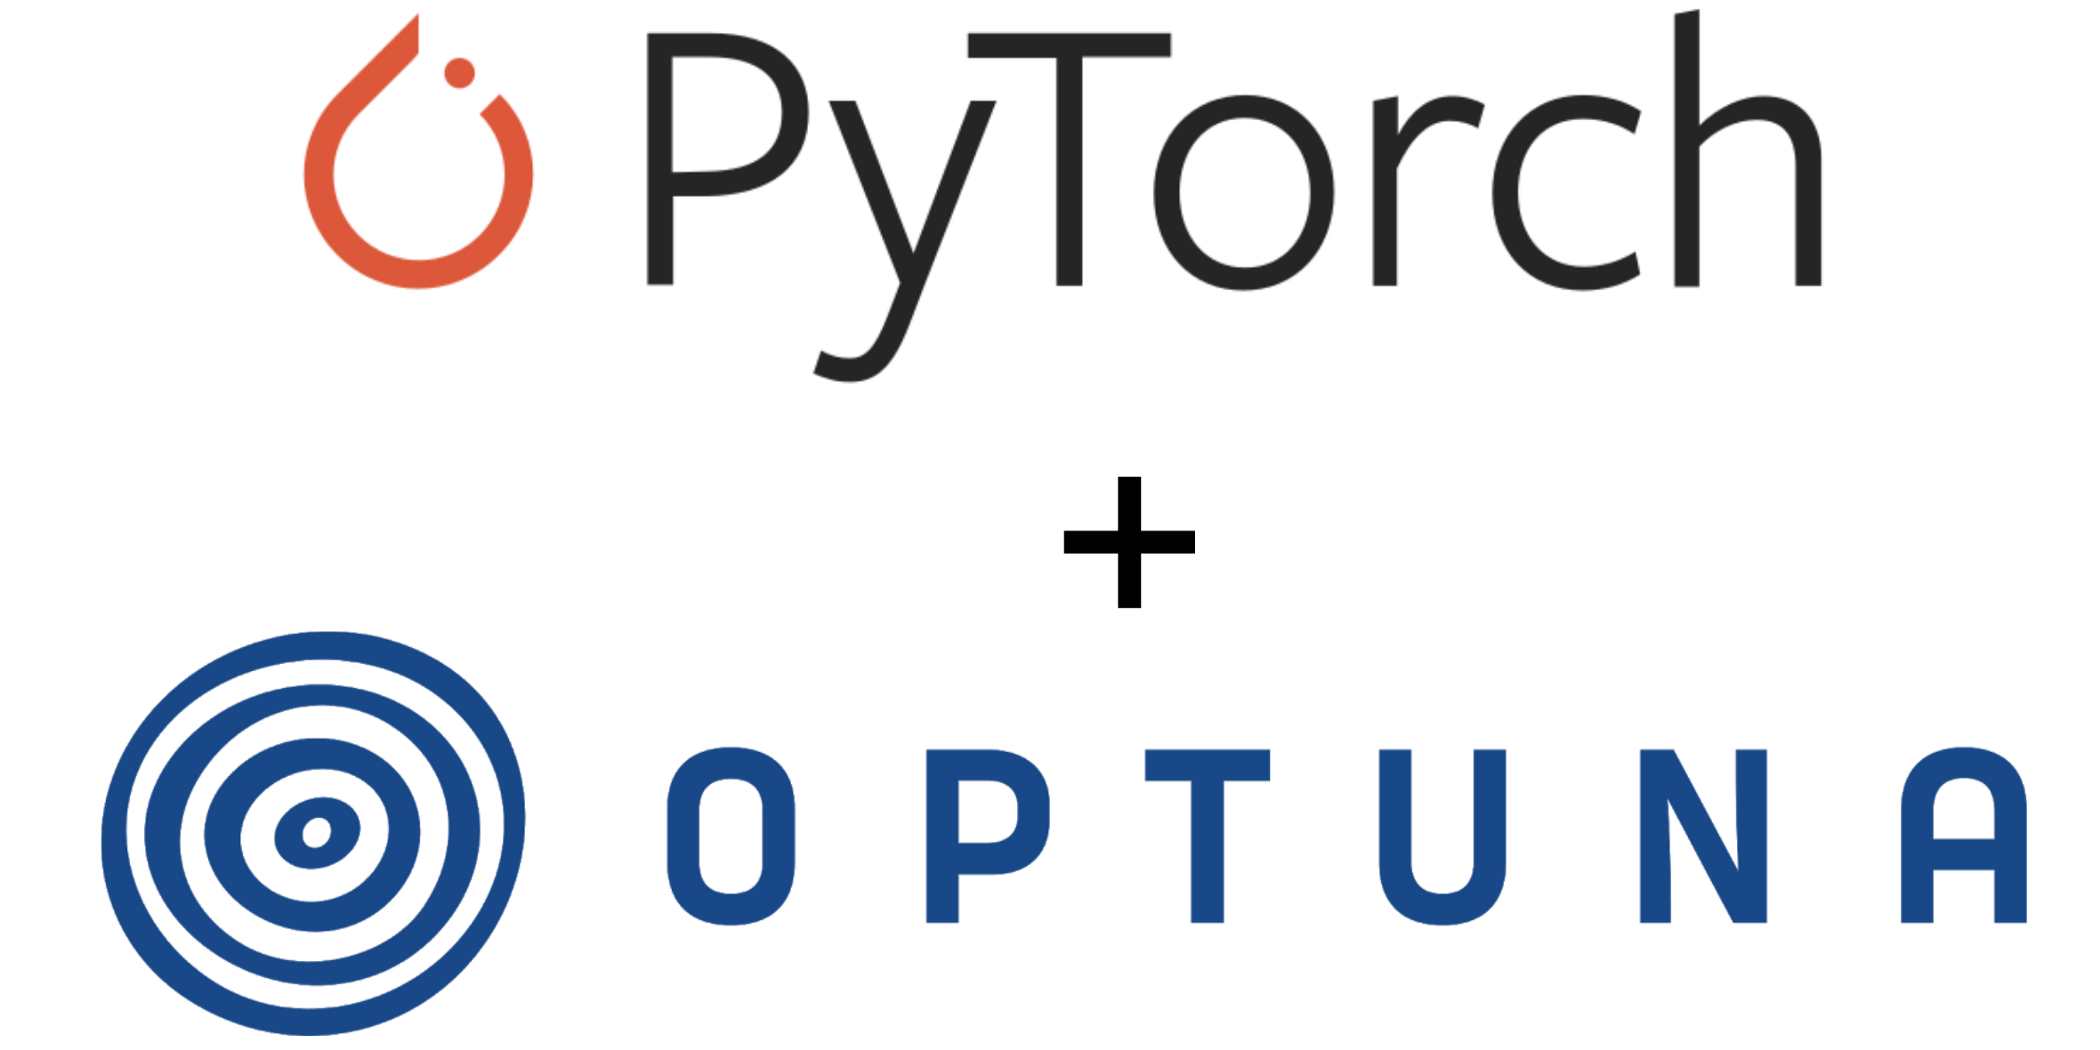

In [ ]:
pip install optuna

In [ ]:

loss = BCEWithLogitsLoss()


def objective(trial):

    def evaluate():

          model.eval()

          len_validation, validation_loss, f1_sum = 0.0 ,0.0, 0.0

          with torch.no_grad():

            for batch in tqdm(validation_dataloader):

              inputs,targets = batch
                  
              a = inputs.to(device)

              y_true = targets.float().to(device)

              y_pred = model(a).squeeze()

              loss_value = loss(y_pred,y_true)

              validation_loss += loss_value.item()

              len_validation += 1
            
            return validation_loss/len_validation

    epochs = 15
    device = "cuda"

    # Generate the model.
    model = SegmentationModel(decoder_blocks_list, pretrained = True, freeze = False, batch_norm=False).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1)
    #momentum = trial.suggest_uniform('momentum', 0.4, 0.99)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)#, momentum = momentum

    for epoch in range(epochs):
                
          epoch_loss, epoch_val_loss, len_train  = 0.0 ,0.0, 0.0

          model.train()

          for batch in tqdm(test_dataloader):

            inputs,targets = batch

            targets = targets.float()  

            a = inputs.to(device)
            b = targets.to(device)

            model_out = model(a).squeeze()

            loss_value =  loss(model_out,b)
            loss_value.backward()  

            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss_value.item()
            len_train += 1
          
          avg_epoch_loss = epoch_loss / len_train

          avg_validation_loss = evaluate()

          print("Epoch: {} train loss = {:0.8f} validation loss = {:0.8f} ".format(epoch, avg_epoch_loss, avg_validation_loss))

          trial.report(avg_validation_loss, epoch)

          # Handle pruning based on the intermediate value.
          if trial.should_prune():

            raise optuna.exceptions.TrialPruned()

    return avg_validation_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#**TRAINING**

##**Trainer class**

In [ ]:
class Trainer():

  def __init__(self,
               optimizer,
               loss,
               model,
               train_dataloader,
               test_dataloader,
               epochs: int = 1,
               device: str = "cuda",
               scheduler = None
               ):
    
    self.epochs = epochs
    self.optimizer = optimizer
    self.loss = loss
    self.model = model
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.scheduler = scheduler
    self.device = device

  def train(self):
    for epoch in range(self.epochs):
            
      epoch_loss = 0.0
      epoch_val_loss = 0.0
      len_train = 0.0
      dice_score = 0.0
      self.model.train()
      for batch in tqdm(self.train_dataloader):

        inputs,targets = batch
        targets = targets.float()      
        a = inputs.to(device)
        b = targets.to(device)

        model_out = self.model(a)

        #model_out.shape = torch.Size([16, 1, 256, 256])

        model_out = model_out.squeeze()

        loss_value =  self.loss(model_out,b)

        loss_value.backward()  

        self.optimizer.step()

        if self.scheduler is not None:

          self.scheduler.step()

        self.optimizer.zero_grad()

        epoch_loss += loss_value.item()

        #with open('/content/drive/My Drive/Project/Segmentazione/H_Tuning_min'+str(scheduler.base_lr) + 'max' + str(scheduler.max_lr) + '.txt', 'w') as file:
        #file.write(str(epoch)+'\t' + str(epoch_loss) + '\t' + str(epoch_val_loss))

        len_train += 1
      
      avg_epoch_loss = epoch_loss / len_train

      avg_validation_loss, f1 = self.evaluate()

      print("Epoch: {} train loss = {:0.8f} validation loss = {:0.8f} ".format(epoch,
                                                                               avg_epoch_loss,
                                                                               avg_validation_loss))
      
      
      torch.save(model.state_dict(), "/content/train.pt")
    
  def evaluate(self):

      model.eval()

      len_validation = 0.0
      validation_loss = 0.0
      f1_sum = 0.0

      with torch.no_grad():

        for batch in tqdm(self.test_dataloader):

          inputs,targets = batch

          targets = targets.float() 
               
          a = inputs.to(device)

          y_true = targets.to(device)

          y_pred = self.model(a)

          y_pred = y_pred.squeeze()

          loss_value = self.loss(y_pred,y_true)

          validation_loss += loss_value.item()

          len_validation += 1

          y_pred = (y_pred >= 0.5) * 1

          numpy_true = y_true.detach().clone().cpu()
          numpy_pred = y_pred.detach().clone().cpu()

          numpy_true = numpy_true.reshape(-1)
          numpy_pred = numpy_pred.reshape(-1)

          numpy_true = numpy_true.float().numpy()
          numpy_pred = numpy_pred.float().numpy()

          f1_sum += f1_score(numpy_true, numpy_pred)

        avg_f1 = f1_sum / len_validation
        print("Validation f1-score = {:0.8f} ".format(avg_f1))
        
        return validation_loss/len_validation, avg_f1


##**Trainer**

In [ ]:
#####MODEL#####
model = SegmentationModel(decoder_blocks_list, pretrained = True, freeze = False, batch_norm=True).to("cuda")

#####MODEL SUMMARY#####
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



Number of parameters: 32210785


Since we are using a batch size of 16, each epoch will have 155 (len(train_ds)/16) training iterations. We are also setting max_epochs to 50, which gives a total of 7750 (max_epochs*155) training iterations. We construct our Cyclic Learning Rate policy to peak at the 25th epoch by setting step_size_up to 3875.

In [ ]:
class WarmRestart(CosineAnnealingLR):
    """
    Parameters
    ----------
    optimizer
        wrapped optimizer.
    T_max
        maximum number of iterations.
    T_mul
        multiplier for `T_max`.
    eta_min
        minimum learning rate.
        Default: 0.
    last_epoch
        the index of last epoch.
        Default: -1.
    """

    def __init__(self, optimizer, T_max, T_mul=1, eta_min=0, last_epoch=-1):
        self.T_mul = T_mul
        super().__init__(optimizer, T_max, eta_min, last_epoch)

    def get_lr(self):
        if self.last_epoch > self.T_max:
            self.last_epoch = 0
            self.T_max *= self.T_mul
        return super().get_lr()

In [ ]:
n = math.ceil(epochs*len(train_dataloader)/2)
print(n)

#####DEVICE#####
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

#####OPTIMIZERS#####
#optimizer = torch.optim.Adam(params = model.parameters(), lr = lr, weight_decay = weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#####SCHEDULER#####
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                  base_lr = 0.002, 
                                  max_lr = 0.4, 
                                  step_size_up=n,
                                  step_size_down=n, 
                                  mode='triangular', 
                                  gamma=1.0, 
                                  scale_fn=None, 
                                  scale_mode='cycle', 
                                  cycle_momentum=True, 
                                  base_momentum=0.8, 
                                  max_momentum=0.9, 
                                  last_epoch=-1)


scheduler = WarmRestart(optimizer, 
                        T_max = 15, 
                        T_mul=1, 
                        eta_min=0.002,
                        last_epoch=-1)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1, last_epoch=-1)

#####LOSSES#####
#loss = DiceLoss() 
loss = BCEWithLogitsLoss()


t = Trainer(optimizer = optimizer                            
            ,loss = loss
            ,model = model
            ,train_dataloader = train_dataloader
            ,test_dataloader=test_dataloader
            ,epochs=epochs
            ,device = device
            ,scheduler = scheduler)

3875


In [ ]:
#model.load_state_dict(torch.load("/content/drive/My Drive/Project/Segmentazione/train.pt"))

model.load_state_dict(torch.load("/content/drive/My Drive/Project/Segmentazione/train.pt"))
model.eval()

In [ ]:
#t.train()

Sample shape  torch.Size([1, 3, 256, 256])
Target shape  torch.Size([256, 256])
(batch_size, channels, w, h)
LOSS_VALUE  tensor(0.0908, device='cuda:0')


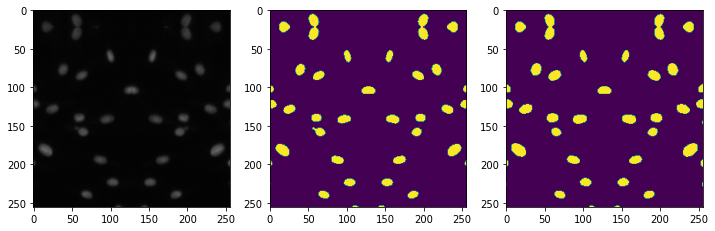

In [ ]:
check_model(model, validation_dataloader)

#**Save and load the Model**

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFYr_IwORUxHlQFrzPZSjocHAcDi1ZXT5OgL57yCXqe0T3CSsUytps
Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Project/Segmentazione/train_1.pt")

#**Model performances**

We are going to load cancer images

In [ ]:
#img1 = np.load('/content/img_38.npy')
PIL_X = Image.open("/content/colosseo.png").convert("RGB")
mage = TF.to_tensor(PIL_X).float()
#img2 = np.load('/content/img_37.npy')
#img3 = np.load('/content/img_42.npy')

torch.Size([1, 3, 256, 256])


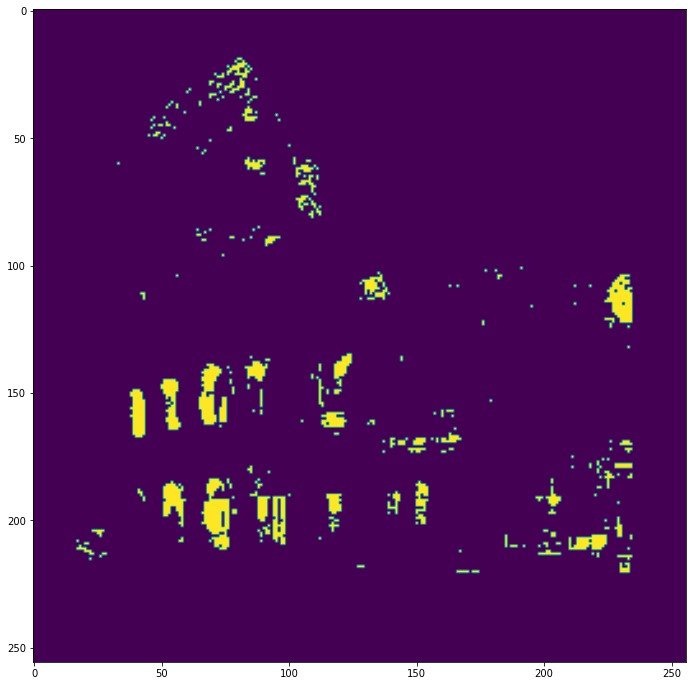

In [ ]:
#tensor_1 = torch.tensor(img1)
#tensor_1 = tensor_1.unsqueeze(0)
#print(mage.shape)

#tensor_1 = torch.einsum("abcd->adbc",tensor_1).float()
mage = mage.unsqueeze(0)
print(mage.shape)

#mage = torch.einsum("bxcy->bcxy",mage)
out = model(mage.cuda())

out_1 = out.detach().cpu()
out_1 = ( out_1 >= 0.5 )*1
out_1 = out_1.squeeze()
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 1
plt.imshow(out_1)
plt.show()
